### Deep Learning for Financial Time Series (DL)

By: Omkar Kharkar <br>

This notebook contains my code for the CQF final project, Deep Learning for Financial Time Series (DL).

In [1]:
%%time
# Load in the Libraries here -->

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Basic Imports
import os
import random
import datetime as dt
# import pandas_ta as ta
from pathlib import Path
import types
import pytz

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Collection Imports

from typing import cast
from urllib3 import HTTPResponse
import urllib, json
import requests
import time
from tqdm.notebook import tqdm
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries

# EDA Imports

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import featuretools as ft
from featuretools.primitives import Lag, RollingMean, RollingMin, RollingMax

# Plotting & outputs
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

# tsfresh imports
import tsfresh

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot
from scikitplot.metrics import plot_confusion_matrix, plot_roc

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

# tensorflow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, BatchNormalization, Bidirectional

# kerastuner
import kerastuner as kt
from kerastuner import HyperParameter, HyperParameters
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband

# Portfolio Analysis
import pyfolio as pf
import empyrical

print("Current Working Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("TensorFlow version: ", tf.__version__)
print("Keras Tuner Version: ", kt.__version__)
print("GPU for TF: ", tf.config.list_physical_devices('GPU'))

Current Working Directory:  /home/ubuntu
Numpy version:  1.23.4
Pandas version:  1.5.1
TensorFlow version:  2.9.1
Keras Tuner Version:  1.0.2
GPU for TF:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU times: user 5.06 s, sys: 5.88 s, total: 10.9 s
Wall time: 4.84 s


### 1a. Loading in the Data

I'll be using the following code (written as a function if multiple calls are needed) to generate the raw data from AlphaVantage. For this assignment, I'll be using Eastman Chemical Company (NYSE:EMN), as part of my analysis.

**Note:** In Exam 3, which involved a similar setup for machine learning on equity data, there was note that stated "Do not choose: FX tickers (GBPUSD), equities with market cap over 100 bln. USD". I will assume that this rule holds here. The market cap of EMN is approx. 10B USD at the time of this writing.

In [15]:
def get_ticker_data(API_KEY, TICKER, FREQ):
    """
    Function to retrieve data using the AlphaVantage API, given an API_KEY, Ticker and Frequency indicator
    """

    ts = TimeSeries(key=API_KEY, output_format='pandas')
    ti = TechIndicators(key=API_KEY, output_format='pandas')
    
    tech_indicator_raw = """SMA Premium
    EMA Premium
    WMA
    DEMA
    TEMA
    TRIMA
    KAMA
    MAMA
    VWAP Premium
    T3
    MACD Premium
    MACDEXT
    STOCH Premium
    STOCHF
    RSI Premium
    STOCHRSI
    WILLR
    ADX Premium
    ADXR
    APO
    PPO
    MOM
    BOP
    CCI Premium
    CMO
    ROC
    ROCR
    AROON Trending
    AROONOSC
    MFI
    TRIX
    ULTOSC
    DX
    MINUS_DI
    PLUS_DI
    MINUS_DM
    PLUS_DM
    BBANDS Premium
    MIDPOINT
    MIDPRICE
    SAR
    TRANGE
    ATR
    NATR
    AD Trending
    ADOSC
    OBV Trending
    HT_TRENDLINE
    HT_SINE
    HT_TRENDMODE
    HT_DCPERIOD
    HT_DCPHASE
    HT_PHASOR"""
    
    premium_ti = set()
    standard_ti = set()
    for line in tech_indicator_raw.splitlines():
        components = line.split()
        if len(components) > 1 and components[1] == "Premium":
            premium_ti.add(components[0])
        else:
            standard_ti.add(components[0])
    print("Premium:", premium_ti)
    print("Standard:", standard_ti)
    
    standard_api_strings = {"get_" + i.lower().replace("_", ""):i for i in standard_ti}    
    standard_apis = {standard_api_strings[i]: getattr(ti, i) for i in dir(ti) if i in standard_api_strings}
    
    print("Retrieving Data From API...")
    data_frames = dict()
    for ind_name, api in tqdm(standard_apis.items()):
        data, meta_data = api(symbol=TICKER, interval=FREQ)
        data_frames[ind_name] = data
        time.sleep(15)
    data_frames.keys()
    print("Done Loading Data !")
    
    now = dt.datetime.now(pytz.timezone('America/New_York'))
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S").replace("/", "_").replace(":", "_").replace(" ", "_")

    path = str("final_proj_csvs_" + dt_string)

    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Directory {path} Created !")
    for ind_name, df in data_frames.items():
        df.to_csv(f"{path}/{ind_name}.csv")

    data, meta_data = ts.get_daily_adjusted(TICKER, outputsize='full')
    data.to_csv(f"{path}/daily_adj.csv")

    return path

In [16]:
current_file_path = get_ticker_data(API_KEY="", TICKER="EMN", FREQ = "daily")

Premium: {'VWAP', 'CCI', 'SMA', 'EMA', 'STOCH', 'MACD', 'RSI', 'BBANDS', 'ADX'}
Standard: {'PLUS_DM', 'AROONOSC', 'OBV', 'MINUS_DM', 'MIDPOINT', 'MACDEXT', 'TRIX', 'CMO', 'MIDPRICE', 'ADXR', 'T3', 'STOCHF', 'BOP', 'ROCR', 'HT_TRENDLINE', 'HT_DCPERIOD', 'MFI', 'TEMA', 'PPO', 'ROC', 'WMA', 'STOCHRSI', 'MAMA', 'ULTOSC', 'ADOSC', 'HT_SINE', 'AROON', 'DX', 'TRANGE', 'SAR', 'APO', 'AD', 'TRIMA', 'MOM', 'WILLR', 'HT_PHASOR', 'KAMA', 'MINUS_DI', 'ATR', 'HT_TRENDMODE', 'NATR', 'DEMA', 'PLUS_DI', 'HT_DCPHASE'}
Retrieving Data From API...


  0%|          | 0/34 [00:00<?, ?it/s]

Done Loading Data !
Directory final_proj_csvs_2023_01_08_17_00_23 Created !


### 1b. Prepare the data for modeling

Using the CSV files pulled from AlphaVantage (please see above), I will left join the data to the daily returns file (daily_adj.csv), which will ultimately, contain the dataset to be used for modeling. In this case, I'll use the percent change of the Close Prices to calculate the returns. Additionally, I'll assume that a daily return greater than 1% is considered "positive" (label of 1, and in this case the up move), and otherwise "negative" or a label of 0.

**Note:** Due to duplicate removals, in an effort to prevent redundant columns, data from STOCHF.csv and STOCHRSI.csv are not included in the dataset model_df output below.

In [239]:
def prepare_data_for_modeling(filepath, remove_list=['.ipynb_checkpoints', 'daily_adj.csv'], daily_adj_filepath:str="daily_adj.csv",
                              start_date='2017-01-01', end_date='2022-12-31', return_threshold=0.01 ):
    """
    Prepares a dataset to be used for modeling and later, backtesting analysis using the CSV files obtained from AlphaVantage,
    given a start date, end date and threshold for which returns should be marked as '1' vs '0'.
    """
    filelist = os.listdir(f"{filepath}")
    for item in remove_list:
        if item in filelist:
            filelist.remove(item)
    
    # Merge Data Here to daily_adj.csv -->
    model_df = pd.read_csv(f"{current_file_path}/{daily_adj_filepath}")
    for file in filelist:
        new_file = pd.read_csv(str(f"{current_file_path}/" + file))
        model_df = pd.merge(left=model_df, right=new_file, on=['date'], how='left')

    # Find all columns that have _x or _y in their names (duplicates) and remove them
    col_list = model_df.columns.tolist()
    col_list_dups = [x for x in col_list if "_x" in x or "_y" in x]
    model_df.drop(col_list_dups, axis=1, inplace=True)

    #Rename columns
    model_df.rename(columns={'1. open':'Open',
                             '2. high':'High',
                             '3. low':'Low',
                             '4. close':'Close',
                             '5. adjusted close':'Adjusted_Close',
                             '6. volume':'Volume',
                             '7. dividend amount':'Dividend_Amount',
                             '8. split coefficient':'Split_Coefficient'}, inplace=True)
    
    # Sort the dataframe in ascending order, and construct the target variable
    model_df.sort_values(inplace=True, by=['date'], ascending=True)
    model_df = pd.DataFrame(model_df.loc[(model_df['date'] >= start_date) & (model_df['date'] <= end_date), :])
    model_df['Forward_Return'] = model_df['Close'].pct_change().shift(-1).fillna(0)
    model_df['Return_Target'] = np.where(model_df['Forward_Return'] > return_threshold, 1, 0)

    model_df.set_index(['date'], inplace=True)
    model_df['Return_Target'].value_counts()
    
    date_str = filepath.replace('final_proj_csvs_', "")
    model_df.to_csv(f"Modeling_Dataset_Raw_{date_str}.csv")
    
    return model_df

In [75]:
%%time

model_df = prepare_data_for_modeling(current_file_path)
model_df

CPU times: user 316 ms, sys: 5.44 ms, total: 322 ms
Wall time: 321 ms


,Open,High,Low,Close,Adjusted_Close,Volume,Dividend_Amount,Split_Coefficient,MAMA,FAMA,...,AROONOSC,TEMA,ADXR,MOM,BOP,SAR,PPO,ROCR,Forward_Return,Return_Target
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,75.84,76.63,74.9000,75.92,63.482279,1270571.0,0.0,1.0,58.6629,58.1480,...,10.0,63.4412,29.5211,1.4889,0.0462,64.6153,0.6083,1.0240,0.016596,1
2017-01-04,76.27,77.35,76.1806,77.18,64.535857,980570.0,0.0,1.0,58.7217,58.1509,...,10.0,63.6915,29.4322,2.1271,0.7782,62.6294,0.5129,1.0341,0.003887,0
2017-01-05,77.27,78.02,76.8300,77.48,64.786709,2053765.0,0.0,1.0,58.7823,58.1541,...,100.0,63.9596,29.6045,2.1454,0.1765,62.6294,0.4757,1.0342,0.000258,0
2017-01-06,77.62,77.90,76.9700,77.50,64.803433,1112245.0,0.0,1.0,58.8425,58.1575,...,95.0,64.1805,29.8986,0.9244,-0.1290,62.6816,0.3988,1.0145,-0.011484,0
2017-01-09,77.32,78.33,76.5300,76.61,64.059239,1233271.0,0.0,1.0,58.8947,58.1612,...,20.0,64.1644,30.0265,-0.5425,-0.3944,62.7327,0.3353,0.9916,0.009398,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,81.39,82.28,80.8847,82.18,82.180000,418466.0,0.0,1.0,89.4064,97.0238,...,-35.0,81.8447,13.2662,-4.0113,0.5662,87.5894,-0.9938,0.9535,0.004502,0
2022-12-27,82.01,82.75,81.6300,82.55,82.550000,519245.0,0.0,1.0,89.3378,96.9854,...,-35.0,81.8174,12.9120,-1.1540,0.4821,87.2806,-1.1885,0.9862,-0.029073,0
2022-12-28,82.77,82.98,79.9000,80.15,80.150000,717144.0,0.0,1.0,89.2460,96.9467,...,-35.0,81.1833,12.6589,-4.3270,-0.8506,86.9842,-1.4589,0.9488,0.025452,1


### 2. Exploratory Data Analysis

Using Pandas Profiling, I will generate a Pandas Profiling report to explore the data from a time series standpoint. Note that the option "tsmode=True" enables the data to be analyzed from a Time Series standpoint. <br>

model_df can be saved to a CSV file. I will read in data from this csv file to prevent having to read in the data and prepare data steps required in the previous cells.

In [86]:
def generate_eda(df_x=pd.DataFrame, reset_index=True):
    """
    Generates Exploratory Data Analysis using Pandas Profiling for the modeling dataset
    """
    df = df_x.copy(deep=True)
    if reset_index:
        df.reset_index(inplace=True)
        df.rename(columns={'index':'id'}, inplace=True)
    profile = ProfileReport(df, tsmode=True, minimal=True, title="Eastman Chemical Profile Report")
    profile.to_file("EMN_Profile_Report.html")

    return

In [87]:
%%time

generate_eda(df_x=model_df, reset_index=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 27s, sys: 7min 7s, total: 9min 35s
Wall time: 34.8 s


### 3. Cleaning the Data

Check for: <br>

- Missing Values (Imputation)
- Any questionable values from the Pandas Profiling Report obtained above

In [79]:
%%time
print(model_df['Return_Target'].value_counts())
model_df.isna().sum()

0    1126
1     384
Name: Return_Target, dtype: int64
CPU times: user 3.42 ms, sys: 0 ns, total: 3.42 ms
Wall time: 3.01 ms


id                   0
date                 0
Open                 0
High                 0
Low                  0
Close                0
Adjusted_Close       0
Volume               0
Dividend_Amount      0
Split_Coefficient    0
MAMA                 0
FAMA                 0
TRIX                 0
CMO                  0
MACD                 0
MACD_Signal          0
MACD_Hist            0
MIDPOINT             0
APO                  0
T3                   0
MIDPRICE             0
KAMA                 0
TRIMA                0
MFI                  0
ATR                  0
WILLR                0
NATR                 0
DEMA                 0
ROC                  0
DX                   0
Aroon Down           0
Aroon Up             0
Chaikin A/D          0
TRANGE               0
ADOSC                0
OBV                  0
WMA                  0
ULTOSC               0
AROONOSC             0
TEMA                 0
ADXR                 0
MOM                  0
BOP                  0
SAR        

### 4. Feature Engineering

This step consists of the following ideas:

**FeatureTools Generation**<br>
Using FeatureTools, I will generate time series features for predicting the Return Target. TSFresh can be used as one way to do feature selection, the other being using Dense layers stacked on top of LSTM layers to reduce features. Therefore, 2 different datasets will be used for this project: (1) Full Feature Set and (2) TSFresh Reduced Dataset.

**Ordinal Encoding** <br>
Categorical values will be encoded using ordinal encoding, so they can be processed as numbers. Note: Given that the dataset is not shuffled, ordinal encoding will be applied before train test and split, so there are no missing values. Otherwise, the test set date data will be encoded as "Missing" if the encoder does not run on the full dataset.

**Standard Scaling** <br>
Given that we are working with LSTM's (deep learning models), I will standard scale the values so that this not affect training. The scaler will be first fit to the training data, and then applied on the test data.

In [4]:
# Load data in here, if you need restart the kernel
model_df = pd.read_csv("Modeling_Dataset_Raw.csv")
model_df

,date,Open,High,Low,Close,Adjusted_Close,Volume,Dividend_Amount,Split_Coefficient,MAMA,...,AROONOSC,TEMA,ADXR,MOM,BOP,SAR,PPO,ROCR,Forward_Return,Return_Target
0,2017-01-03,75.84,76.63,74.9000,75.92,63.482279,1270571.0,0.0,1.0,58.6629,...,10.0,63.4412,29.5211,1.4889,0.0462,64.6153,0.6083,1.0240,0.016596,1
1,2017-01-04,76.27,77.35,76.1806,77.18,64.535857,980570.0,0.0,1.0,58.7217,...,10.0,63.6915,29.4322,2.1271,0.7782,62.6294,0.5129,1.0341,0.003887,0
2,2017-01-05,77.27,78.02,76.8300,77.48,64.786709,2053765.0,0.0,1.0,58.7823,...,100.0,63.9596,29.6045,2.1454,0.1765,62.6294,0.4757,1.0342,0.000258,0
3,2017-01-06,77.62,77.90,76.9700,77.50,64.803433,1112245.0,0.0,1.0,58.8425,...,95.0,64.1805,29.8986,0.9244,-0.1290,62.6816,0.3988,1.0145,-0.011484,0
4,2017-01-09,77.32,78.33,76.5300,76.61,64.059239,1233271.0,0.0,1.0,58.8947,...,20.0,64.1644,30.0265,-0.5425,-0.3944,62.7327,0.3353,0.9916,0.009398,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,81.39,82.28,80.8847,82.18,82.180000,418466.0,0.0,1.0,89.4064,...,-35.0,81.8447,13.2662,-4.0113,0.5662,87.5894,-0.9938,0.9535,0.004502,0
1506,2022-12-27,82.01,82.75,81.6300,82.55,82.550000,519245.0,0.0,1.0,89.3378,...,-35.0,81.8174,12.9120,-1.1540,0.4821,87.2806,-1.1885,0.9862,-0.029073,0
1507,2022-12-28,82.77,82.98,79.9000,80.15,80.150000,717144.0,0.0,1.0,89.2460,...,-35.0,81.1833,12.6589,-4.3270,-0.8506,86.9842,-1.4589,0.9488,0.025452,1
1508,2022-12-29,80.54,82.70,80.5400,82.19,82.190000,552187.0,0.0,1.0,89.1754,...,-35.0,81.2055,12.5026,-3.6445,0.7639,86.6996,-1.7304,0.9575,-0.009125,0


In [5]:
%%time

def generate_features_ft(df:pd.DataFrame, gap, window_length):
    """
    Generates features given a dataframe, gap and window length, using FeatureTools for Time Series Feature Construction
    """
    if 'id' not in df.columns.tolist():
        df.reset_index(inplace=True)
        df.rename(columns={'index':'id'}, inplace=True)

    es = ft.EntitySet(id="stock_data")
    es = es.add_dataframe(
        dataframe_name="technical_data",
        dataframe=df,
        index="id",
        time_index="date"
    )
    
    # List the Featuretools primitives to be used here -->
    
    datetime_primitives = ["Day", "Year", "Weekday", "Month"]

    delaying_primitives = [Lag(periods=i + gap) for i in range(window_length)]

    rolling_mean_primitive = RollingMean(
        window_length=window_length, gap=gap, min_periods=window_length
    )

    rolling_min_primitive = RollingMin(
        window_length=window_length, gap=gap, min_periods=window_length
    )
    
    X_features, fe_list = ft.dfs(
        entityset=es,
        target_dataframe_name="technical_data",
        trans_primitives=(
            datetime_primitives
            + delaying_primitives
            + [rolling_mean_primitive, rolling_min_primitive]
        ),
    )
    
    X_features.fillna(value=1.0, inplace=True)
    print("FeatureTools Generated Features: \n")
    display(X_features)
    
    return X_features, fe_list

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 8.34 µs


In [6]:
%%time

def scale_data(df_train:pd.DataFrame, df_test:pd.DataFrame, cat_features:list):
    """
    Scales data using Standard Scaler, fit to the training data, and applied to
    the test data.    
    """
    num_features = df_train.columns.tolist()
    for feature in cat_features:
        num_features.remove(feature)
    
    df_train_scaled = df_train.copy(deep=True)
    df_test_scaled = df_test.copy(deep=True)
    
    scaler = StandardScaler()
    df_train_scaled[num_features] = scaler.fit_transform(df_train[num_features])
    df_test_scaled[num_features] = scaler.transform(df_test[num_features])
    
    return df_train_scaled, df_test_scaled


def encode_data(df:pd.DataFrame, cat_features:list):
    """
    Encodes categorical variables using Ordinal Encoding
    """
    df_encoded = df.copy(deep=True)
    encoder = OrdinalEncoder()
    df_encoded[cat_features] = encoder.fit_transform(df[cat_features])

    return df_encoded, encoder

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 6.91 µs


In [7]:
def generate_time_series_data(X:pd.DataFrame, Y:pd.Series, seqlen, scale=True, cat_features=["DAY(date)", "MONTH(date)", 'WEEKDAY(date)', 'YEAR(date)']):
    """
    Generates the time series data to be used by the Keras model using TimeSeriesGenerator
    for training, validation and test sets, along with the seqlen and dimension of the dataset (num_features)
    """
    
    num_features = X.shape[1]
    
    # Splitting the dataframes into training and testing data, for scaling
    X_, X_test, Y_, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
    
    # Scaling the dataframes here -->
    if scale == True:
        X_, X_test = scale_data(df_train=X_, df_test=X_test, cat_features=cat_features)
    
    # Splitting into Train / Valid / Test and converting to Numpy for TimeSeriesGenerator
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_.to_numpy(), Y_.to_numpy(), test_size=0.3, shuffle=False)
    X_test = X_test.to_numpy()
    Y_test = Y_test.to_numpy()

    # Output the train and test data size
    print(f"Train Size {X_train.shape}, {Y_train.shape}")
    print(f"Valid Size {X_valid.shape}, {Y_valid.shape}")
    print(f"Test Size {X_test.shape}, {Y_test.shape}")

    # generate train and test sequence data
    g_train = TimeseriesGenerator(X_train, Y_train, length=seqlen)
    g_valid = TimeseriesGenerator(X_train, Y_train, length=seqlen)
    g_test = TimeseriesGenerator(X_test, Y_test, length=seqlen)
    
    # verify length
    print("Length of Train Generator: ", len(g_train))
    print("Length of Valid Generator: ", len(g_valid))
    print("Length of Test Generator: ", len(g_test))
    
    print("\n Training Batch Sizes: \n ")
    for i in range(len(g_train)):
        a, b = g_train[i]
        print(a.shape, b.shape)
        
    print("\n Validation Batch Sizes: \n ")
    for i in range(len(g_train)):
        a, b = g_valid[i]
        print(a.shape, b.shape)
        
    print("\n Test Batch Sizes: \n ")
    for i in range(len(g_test)):
        a, b = g_test[i]
        print(a.shape, b.shape)
    
    return g_train, g_valid, g_test, Y_test, seqlen, num_features

In [8]:
def ts_select_features(X_fe:pd.DataFrame, Y:pd.Series):
    """
    Selects features using tsfreshs' algorithm for feature selection
    
    Input: A pandas DataFrame containing the engineered features (X values)
    Returns: A pandas DataFrame that keeps only the significant features
    """
    X_non_numeric = X_fe.select_dtypes(exclude=['float64', 'int64', 'int32', 'float32'])
    X_numerics = X_fe.drop(X_non_numeric, axis=1)
    X_filtered = tsfresh.select_features(X_numerics, Y)
    
    X_joined = pd.concat([X_filtered, X_non_numeric], axis=1)
    
    print("TSFresh Reduced Features: \n")
    display(X_joined)
    
    return X_joined, X_joined.columns.tolist()

In [9]:
%%time

# Generate the data for fitting models here -->
non_feature_cols = ['Open', 'High', 'Low', 'Close', 'Adjusted_Close', 'Volume', 'Dividend_Amount', 'Split_Coefficient', 
                    'Forward_Return', 'Return_Target']

Y = model_df['Return_Target']
X = model_df.drop(non_feature_cols, axis=1)

# Generate Features Using FeatureTools
X_features, fe_list = generate_features_ft(df=X, gap=2, window_length=10)

# Ordinal Encode data first
X_encoded, encoder = encode_data(df=X_features, cat_features=["DAY(date)", "MONTH(date)", 'WEEKDAY(date)', 'YEAR(date)'])

# Create the TimeseriesGenerators to be used by the Tensorflow Models
g_train, g_valid, g_test, Y_test, seqlen, num_features = generate_time_series_data(X=X_encoded, Y=Y, seqlen=10, scale=True)

# Confirm that the number of rows matches
if Y.shape[0] == X_encoded.shape[0]:
    print("X and Y have the same shape of: ", Y.shape[0])

FeatureTools Generated Features: 



,MAMA,FAMA,TRIX,CMO,MACD,MACD_Signal,MACD_Hist,MIDPOINT,APO,T3,...,"ROLLING_MIN(date, T3, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, TEMA, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, TRANGE, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, TRIMA, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, TRIX, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, ULTOSC, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, WILLR, window_length=10, gap=2, min_periods=10)","ROLLING_MIN(date, WMA, window_length=10, gap=2, min_periods=10)",WEEKDAY(date),YEAR(date)
id,,,,,,,,,,,,,,,,,,,,,
0,58.6629,58.1480,0.2217,12.4323,0.3847,0.6595,-0.2748,63.5052,0.3847,64.4434,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1,2017
1,58.7217,58.1509,0.2128,20.7719,0.3248,0.6013,-0.2765,63.6215,0.3248,64.4708,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2,2017
2,58.7823,58.1541,0.2055,22.6189,0.3017,0.5363,-0.2346,63.8377,0.3017,64.4949,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,3,2017
3,58.8425,58.1575,0.1995,22.7453,0.2535,0.4638,-0.2103,63.8460,0.2535,64.5188,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,4,2017
4,58.8947,58.1612,0.1933,14.0219,0.2134,0.3958,-0.1824,63.8460,0.2134,64.5417,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,89.4064,97.0238,0.1729,-1.8667,-0.8363,-0.2244,-0.6119,84.0056,-0.8363,85.8884,...,83.8109,82.4698,0.9994,84.7698,0.2095,36.5446,-96.0504,83.7842,4,2022
1506,89.3378,96.9854,0.1560,-0.2580,-1.0002,-0.3967,-0.6036,84.0056,-1.0002,85.7992,...,84.2053,82.0083,0.9994,84.5961,0.1909,36.5446,-96.0504,83.4949,1,2022
1507,89.2460,96.9467,0.1377,-9.9661,-1.2259,-0.5907,-0.6352,83.7256,-1.2259,85.6730,...,84.5594,81.8447,0.9994,84.4168,0.1729,36.5446,-96.0504,83.3032,2,2022


Train Size (845, 472), (845,)
Valid Size (363, 472), (363,)
Test Size (302, 472), (302,)
Length of Train Generator:  7
Length of Valid Generator:  7
Length of Test Generator:  3

 Training Batch Sizes: 
 
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(67, 10, 472) (67,)

 Validation Batch Sizes: 
 
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(67, 10, 472) (67,)

 Test Batch Sizes: 
 
(128, 10, 472) (128,)
(128, 10, 472) (128,)
(36, 10, 472) (36,)
X and Y have the same shape of:  1510
CPU times: user 12.1 s, sys: 0 ns, total: 12.1 s
Wall time: 12.1 s


#### Generate TSFresh Reduced Feature Set

This section generates the TS Reduced Feature Dataset. The resulting variables will be named using "_ts"

In [10]:
# Feature Selection using TSFresh
X_features_ts, feature_list_ts = ts_select_features(X_fe=X_features, Y=Y)

# Ordinal Encode data first
X_encoded_ts, encoder_ts = encode_data(df=X_features_ts, cat_features=["DAY(date)", "MONTH(date)", 'WEEKDAY(date)', 'YEAR(date)'])

# Create the TimeseriesGenerators to be used by the Tensorflow Models
g_train_ts, g_valid_ts, g_test_ts, Y_test_ts, seqlen_ts, num_features_ts = generate_time_series_data(X=X_encoded_ts, Y=Y, seqlen=10, scale=True)

# Confirm that the number of rows matches
if Y.shape[0] == X_encoded_ts.shape[0]:
    print("X and Y have the same shape of: ", Y.shape[0])

TSFresh Reduced Features: 



,NATR,"LAG(NATR, date, periods=2)","LAG(NATR, date, periods=3)","LAG(NATR, date, periods=4)","LAG(NATR, date, periods=5)","ROLLING_MEAN(date, NATR, window_length=10, gap=2, min_periods=10)","LAG(NATR, date, periods=6)","ROLLING_MIN(date, NATR, window_length=10, gap=2, min_periods=10)","LAG(NATR, date, periods=7)","LAG(TRANGE, date, periods=7)",...,"LAG(ADXR, date, periods=9)",ADXR,"LAG(ADXR, date, periods=8)","LAG(ADXR, date, periods=2)","LAG(ADXR, date, periods=7)","LAG(ADXR, date, periods=6)",DAY(date),MONTH(date),WEEKDAY(date),YEAR(date)
id,,,,,,,,,,,,,,,,,,,,,
0,1.6877,1.0000,1.0000,1.0000,1.0000,1.00000,1.0000,1.0000,1.0000,1.0000,...,1.0000,29.5211,1.0000,1.0000,1.0000,1.0000,3,1,1,2017
1,1.6698,1.0000,1.0000,1.0000,1.0000,1.00000,1.0000,1.0000,1.0000,1.0000,...,1.0000,29.4322,1.0000,1.0000,1.0000,1.0000,4,1,2,2017
2,1.6570,1.6877,1.0000,1.0000,1.0000,1.00000,1.0000,1.0000,1.0000,1.0000,...,1.0000,29.6045,1.0000,29.5211,1.0000,1.0000,5,1,3,2017
3,1.6337,1.6698,1.6877,1.0000,1.0000,1.00000,1.0000,1.0000,1.0000,1.0000,...,1.0000,29.8986,1.0000,29.4322,1.0000,1.0000,6,1,4,2017
4,1.6875,1.6570,1.6698,1.6877,1.0000,1.00000,1.0000,1.0000,1.0000,1.0000,...,1.0000,30.0265,1.0000,29.6045,1.0000,1.0000,9,1,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2.7950,2.8966,2.9897,3.0900,3.0055,2.92447,3.0431,2.7918,2.8035,2.0970,...,14.9976,13.2662,15.0922,13.5937,14.8931,14.3883,23,12,4,2022
1506,2.7112,2.8804,2.8966,2.9897,3.0900,2.91769,3.0055,2.7918,3.0431,4.1299,...,15.0922,12.9120,14.8931,13.5950,14.3883,14.1238,27,12,1,2022
1507,2.8449,2.7950,2.8804,2.8966,2.9897,2.90952,3.0900,2.7918,3.0055,1.8800,...,14.8931,12.6589,14.3883,13.2662,14.1238,13.8649,28,12,2,2022


Train Size (845, 54), (845,)
Valid Size (363, 54), (363,)
Test Size (302, 54), (302,)
Length of Train Generator:  7
Length of Valid Generator:  7
Length of Test Generator:  3

 Training Batch Sizes: 
 
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(67, 10, 54) (67,)

 Validation Batch Sizes: 
 
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(67, 10, 54) (67,)

 Test Batch Sizes: 
 
(128, 10, 54) (128,)
(128, 10, 54) (128,)
(36, 10, 54) (36,)
X and Y have the same shape of:  1510


In [11]:
# Saving files as CSV's for use later
X_features.to_csv("X_features_full.csv")
X_features_ts.to_csv("X_features_ts.csv")

#### Correlation Analysis

Analyzing the correlations between the ts reduced dataset, for any interesting trends.

<AxesSubplot:>

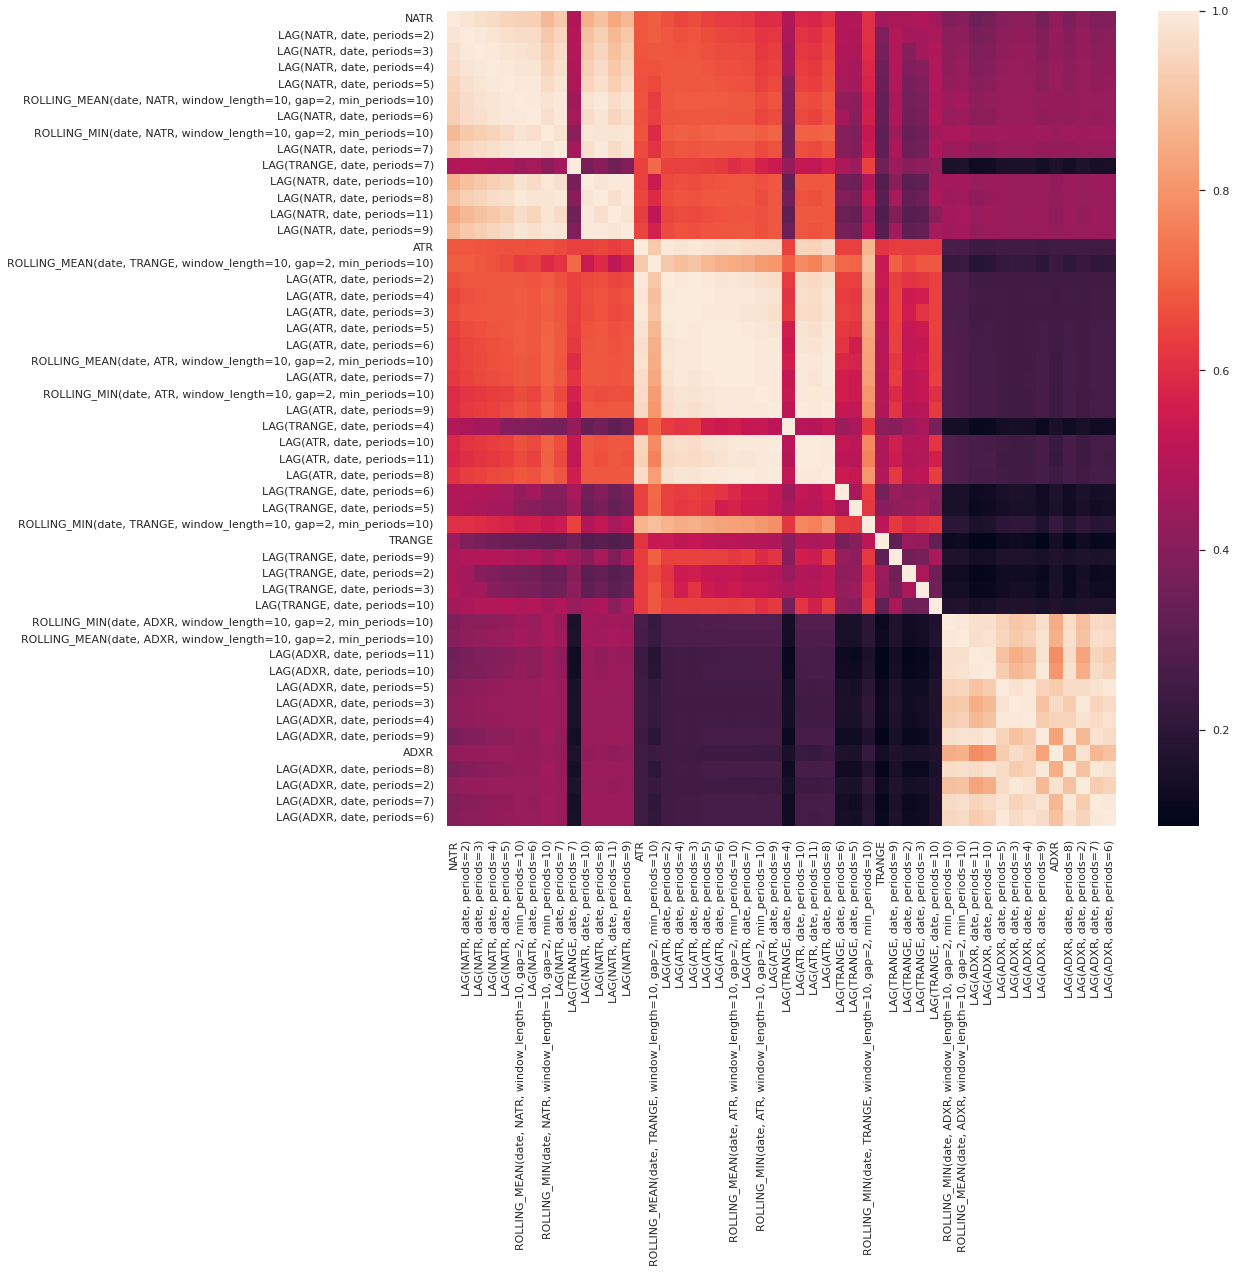

In [161]:
sns.set (rc = {'figure.figsize':(15, 15)})
sns.heatmap(X_features_ts.corr())

##### -------------------------------------------------------------------------------------------------------------------------------------------------------

### 5. Model Building

This section builds baseline LSTM models using varying architectures. The function cwts reweights the classes in the case of imbalanced data.

In [13]:
# Set Class Weights

def cwts(dfs):
    """
    Calculates the class weight based on the counts in dfs, a numpy array or pandas DataFrame
    containing the target variable, Y.
    """
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(dfs))/2 
    w1=(1/c1)*(len(dfs))/2 
    class_weights = {0: w0, 1: w1}
    print("Class Weights: ", class_weights)
    return class_weights

class_weights = cwts(Y)
class_weights

Class Weights:  {0: 0.6705150976909414, 1: 1.9661458333333333}


{0: 0.6705150976909414, 1: 1.9661458333333333}

In [8]:
%%time

def baseline_model_fs(g_train, g_valid, lookback, features, class_weights=class_weights):
    """
    Create a baseline model with initial Dense Layers to perform feature selection,
    when using large feature sets, then pass layers to an LSTM.
    """
    
    tf.keras.backend.clear_session()   

    # Adding Dense layers to compress the model down
    model = Sequential()
    model.add(Dense(units=features, name='Input'))
    model.add(Dense(units=100))
    model.add(Dense(units=50))
    
    model.add(LSTM(units=20, input_shape=(lookback, 50), activation = 'relu', return_sequences=True, name='LSTM1'))
    model.add(Dropout(0.4, name='Dropout1'))
    
    model.add(LSTM(units=20, activation = 'relu', return_sequences=True, name='LSTM2'))
    model.add(Dropout(0.4, name='Dropout2'))
    
    model.add(LSTM(units=20, activation = 'relu', return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))             
    
    # specify optimizer separately (preferred method))
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
    
    my_callbacks = [
        EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True),
    ]
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    # Model fitting
    model.fit(g_train,
              epochs=25, 
              verbose=1,
              callbacks=my_callbacks, 
              shuffle=False,
              class_weight=class_weights,
              validation_data=g_valid)
    
    model.summary()

    return model

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [119]:
model_fs = baseline_model_fs(g_train, g_valid, lookback=seqlen, features=num_features)

Epoch 1/25
7/7 [==============================] - 4s 132ms/step - loss: 0.7241 - precision: 0.2632 - recall: 0.0847 - val_loss: 0.6599 - val_precision: 0.3607 - val_recall: 0.1243
Epoch 2/25
7/7 [==============================] - 0s 43ms/step - loss: 0.7599 - precision: 0.2706 - recall: 0.1299 - val_loss: 0.6728 - val_precision: 0.3048 - val_recall: 0.1808
Epoch 3/25
7/7 [==============================] - 0s 44ms/step - loss: 0.7577 - precision: 0.3333 - recall: 0.0960 - val_loss: 0.6415 - val_precision: 0.2909 - val_recall: 0.0904
Epoch 4/25
7/7 [==============================] - 0s 45ms/step - loss: 0.8246 - precision: 0.3261 - recall: 0.2542 - val_loss: 0.7570 - val_precision: 0.3138 - val_recall: 0.3333
Epoch 5/25
7/7 [==============================] - 0s 44ms/step - loss: 0.7554 - precision: 0.2825 - recall: 0.3559 - val_loss: 0.6565 - val_precision: 0.2934 - val_recall: 0.4011
Epoch 6/25
7/7 [==============================] - 0s 45ms/step - loss: 0.6476 - precision: 0.2338 - reca

In [9]:
# Create a sequential model
def baseline_model(g_train, g_valid, lookback, features, class_weights=class_weights):
    """
    Create a baseline LSTM model.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    model.add(LSTM(units=20, input_shape=(lookback, features), activation = 'elu', return_sequences=True, name='LSTM1'))
    model.add(Dropout(0.4, name='Dropout1'))
    
    model.add(LSTM(units=20, activation = 'relu', return_sequences=True, name='LSTM2'))
    model.add(Dropout(0.4, name='Dropout2'))
    
    model.add(LSTM(units=10, activation = 'relu', return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))             
    
    # specify optimizer separately (preferred method))
    opt = Adam(lr=0.001, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=['accuracy', 
                           Precision(),
                           Recall()])
    model.summary()
    
    # Model fitting
    model.fit(g_train,
              epochs=15, 
              verbose=1, 
    #         callbacks=my_callbacks, 
              shuffle=False,
              class_weight=class_weights,
              validation_data=g_valid)

    return model

In [114]:
%%time

# lstm network
model_baseline = baseline_model(g_train, g_valid, lookback=seqlen, features=num_features)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 10, 20)            39440     
                                                                 
 Dropout1 (Dropout)          (None, 10, 20)            0         
                                                                 
 LSTM2 (LSTM)                (None, 10, 20)            3280      
                                                                 
 Dropout2 (Dropout)          (None, 10, 20)            0         
                                                                 
 LSTM3 (LSTM)                (None, 10)                1240      
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 43,971
Trainable params: 43,971
Non-traina

### 6a. Hyperparameter Tuning

This section tunes hyperparameters and searches for candidate models. <br>

1. Feature Selection with TSFresh
- Test using LSTM, BiDirectional LSTM, GRU Layers

2. Feature Selection using Dense Layers to compress representation
- Test using LSTM BiDirectional LSTM, GRU Layers

In [10]:
def Dense_LSTM_1(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + LSTM layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('LSTM_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('LSTM_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [11]:
def Dense_LSTM_2(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + LSTM layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/8)*numfeat), max_value=int(numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('LSTM_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('LSTM_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, d_units2), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [12]:
def Dense_BiLSTM(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + Bidirectional LSTM layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('LSTM_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('LSTM_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(Bidirectional(LSTM(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='LSTM1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [13]:
def Dense_RNN(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + RNN layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('RNN_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(SimpleRNN(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='RNN1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [14]:
def Dense_BiRNN(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + Bidirectional RNN layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('RNN_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(Bidirectional(SimpleRNN(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='RNN1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [15]:
def Dense_GRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + GRU layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('GRU_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(GRU(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='GRU1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [16]:
def Dense_BiGRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + Bidirectional GRU layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('GRU_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(Bidirectional(GRU(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='GRU1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [17]:
def Dense_LSTM_GRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + LSTM + GRU layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [18]:
def Dense_LSTM_RNN(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + LSTM + RNN layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [19]:
def Dense_LSTM_RNN_GRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + LSTM + RNN + GRU layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, d_units3), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

### 6b. Grid Search Functions

This section defines the grid search techniques used with Keras Tuner:

1. Random Search
2. Hyperband Search

Due to environment limitations, Bayesian Optimization is not used.

In [14]:
def random_search(hypermodel_choice, n_trials=5, n_epochs=10, n_patience=10, g_train=g_train, g_valid=g_valid, class_weights=class_weights):
    """
    Function for doing a Random Search to find the best deep learning model.
    """
    now = dt.datetime.now(pytz.timezone('America/New_York'))
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S").replace("/", "_").replace(":", "_").replace(" ", "_")
    
    log_dir_path = f"./tensorboard/rslogs_{hypermodel_choice.__name__}_{dt_string}"
    callback1 = [EarlyStopping(patience=n_patience, 
                               monitor='val_loss', 
                               mode='min', 
                               verbose=1, 
                               restore_best_weights=True),
                 TensorBoard(log_dir=log_dir_path)]

    rstuner = RandomSearch(
        hypermodel=hypermodel_choice,
        objective="val_loss",
        max_trials=n_trials,
        directory="./keras_tuner",
        project_name=f"rstrials_{hypermodel_choice.__name__}_{dt_string}",
        overwrite=True
    )

    # launch tuning process
    rstuner.search(g_train, epochs=n_epochs, validation_data=g_valid, callbacks=callback1, class_weight=class_weights, shuffle=False)

    best_rshp = rstuner.get_best_hyperparameters()[0]
    print("\n Best Values: \n", best_rshp.values)

    rstuner.results_summary()
    
    best_search_model = rstuner.hypermodel.build(best_rshp)

    best_search_model.fit(g_train,
                          epochs=n_epochs,
                          verbose=1,
                          callbacks=callback1,
                          shuffle=False,
                          class_weight=class_weights,
                          validation_data=g_valid)
    
    best_search_model.summary()
    best_search_model.save(f"./models/rs_{hypermodel_choice.__name__}_{dt_string}")
    
    return rstuner, best_rshp

In [15]:
def hyperband_search(hypermodel_choice, n_trials=1, n_epochs=10, n_patience=10, g_train=g_train, g_valid=g_valid, class_weights=class_weights):
    """
    Function for doing a Hyperband Search to find the best deep learning model.
    """
    now = dt.datetime.now(pytz.timezone('America/New_York'))
    dt_string = now.strftime("%Y/%m/%d %H:%M:%S").replace("/", "_").replace(":", "_").replace(" ", "_")
    
    log_dir_path = f"./tensorboard/hblogs_{hypermodel_choice.__name__}_{dt_string}"
    callback1 = [EarlyStopping(patience=n_patience, 
                               monitor='val_loss', 
                               mode='min', 
                               verbose=1, 
                               restore_best_weights=True),
                 TensorBoard(log_dir=log_dir_path)]
    
    hbtuner = kt.Hyperband(
        hypermodel=hypermodel_choice,
        objective="val_loss",
        max_epochs=n_epochs,
        hyperband_iterations=n_trials,
        directory="./keras_tuner",
        project_name=f"hbtrials_{hypermodel_choice.__name__}_{dt_string}",
        overwrite=True
    )

    # launch tuning process
    hbtuner.search(g_train, epochs=n_epochs, validation_data=g_valid, callbacks=callback1, class_weight=class_weights, shuffle=False)

    best_hbhp = hbtuner.get_best_hyperparameters()[0]
    print("\n Best Values: \n", best_hbhp.values)

    hbtuner.results_summary()
    
    best_search_model = hbtuner.hypermodel.build(best_hbhp)

    best_search_model.fit(g_train,
                          epochs=n_epochs,
                          verbose=1,
                          callbacks=callback1,
                          shuffle=False,
                          class_weight=class_weights,
                          validation_data=g_valid)
    
    best_search_model.summary()
    best_search_model.save(f"./models/hb_{hypermodel_choice.__name__}_{dt_string}")
    
    return hbtuner, best_hbhp

In [127]:
#%load_ext tensorboard
#%tensorboard --logdir ./tensorboard/rslogs

### 6c. Testing the Various Grid Searches and Hypermodel Functions

This section contains the function calls for testing the various hypermodel function and search functions (random, hyperband) to test out a variety of deep learning models. This is to ensure that there are no failures, prior to the full run.

In [60]:
# Testing for errors in the Hypermodels

def test_run_hypermodels(dnn_list:list):
    """
    Test the deep learning architectures in hypermodels to see if they can compile - this is just a test run.
    """
    # dnn_list = [f for f in globals().values() if type(f) == types.FunctionType and 'Dense' in f.__name__]
    pass_list = []
    fail_list = []
    print("List of DL Hypermodels to Test: ", dnn_list)
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = random_search(hypermodel_choice=dnn_func, 
                                               n_trials=5, 
                                               n_epochs=10, 
                                               n_patience=10, 
                                               g_train=g_train,
                                               g_valid=g_valid, 
                                               class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [23]:
%%time

dnn_fn_list =[Dense_LSTM_1,
              Dense_LSTM_2,
             Dense_BiLSTM,
             Dense_RNN,
             Dense_BiRNN,
             Dense_GRU,
             Dense_BiGRU,
             Dense_LSTM_GRU,
             Dense_LSTM_RNN,
             Dense_LSTM_RNN_GRU]

dl_pass_list, dl_fail_list =  test_run_hypermodels(dnn_fn_list)

dl_pass_list
dl_fail_list

Trial 5 Complete [00h 00m 06s]
val_loss: 1.34396493434906

Best val_loss So Far: 0.6396171450614929
Total elapsed time: 00h 00m 34s

 Best Values: 
 {'Dense_2': 464, 'Dense_3': 126, 'LSTM_1': 4, 'RNN_2': 24, 'GRU_3': 20, 'Dropout_rate_1': 0.2, 'Dropout_rate_2': 0.2, 'learning_rate': 0.0018244411719388063, 'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'relu'}
Results summary
Results in ./keras_tuner/rstrials_Dense_LSTM_RNN_GRU_2023_01_09_09_28_49
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Dense_2: 464
Dense_3: 126
LSTM_1: 4
RNN_2: 24
GRU_3: 20
Dropout_rate_1: 0.2
Dropout_rate_2: 0.2
learning_rate: 0.0018244411719388063
activation_1: elu
activation_2: elu
activation_3: relu
Score: 0.6396171450614929
Trial summary
Hyperparameters:
Dense_2: 244
Dense_3: 178
LSTM_1: 8
RNN_2: 8
GRU_3: 24
Dropout_rate_1: 0.1
Dropout_rate_2: 0.0
learning_rate: 0.00012916125399386712
activation_1: elu
activation_2: relu
activation_3: relu
Sc

[]

In [69]:
# Testing for errors in the Hypermodels

def test_run_hypermodels_ts(dnn_list:list):
    """
    Test the deep learning architectures in hypermodels to see if they can compile - this is just a test run.
    """
    # dnn_list = [f for f in globals().values() if type(f) == types.FunctionType and 'Dense' in f.__name__]
    pass_list = []
    fail_list = []
    print("List of DL Hypermodels to Test: ", dnn_list)
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = random_search(hypermodel_choice=dnn_func, 
                                               n_trials=5, 
                                               n_epochs=10, 
                                               n_patience=10, 
                                               g_train=g_train_ts,
                                               g_valid=g_valid_ts, 
                                               class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [70]:
%%time

dnn_ts_list =[LSTM_,
              BiLSTM_,
              RNN_,
              BiRNN_,
              GRU_,
              BiGRU_,
              LSTM_GRU_,
              LSTM_RNN_,
              LSTM_RNN_GRU_]

dl_pass_list, dl_fail_list =  test_run_hypermodels_ts(dnn_ts_list)

dl_pass_list
dl_fail_list

Trial 5 Complete [00h 00m 06s]
val_loss: 0.6233358383178711

Best val_loss So Far: 0.5637820363044739
Total elapsed time: 00h 00m 31s

 Best Values: 
 {'LSTM_1': 8, 'RNN_2': 24, 'GRU_3': 8, 'Dropout_rate_1': 0.30000000000000004, 'Dropout_rate_2': 0.2, 'learning_rate': 0.009763649814155503, 'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu'}
Results summary
Results in ./keras_tuner/rstrials_LSTM_RNN_GRU__2023_01_11_07_06_42
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
LSTM_1: 8
RNN_2: 24
GRU_3: 8
Dropout_rate_1: 0.30000000000000004
Dropout_rate_2: 0.2
learning_rate: 0.009763649814155503
activation_1: elu
activation_2: elu
activation_3: elu
Score: 0.5637820363044739
Trial summary
Hyperparameters:
LSTM_1: 24
RNN_2: 12
GRU_3: 20
Dropout_rate_1: 0.1
Dropout_rate_2: 0.2
learning_rate: 0.002041927912277331
activation_1: elu
activation_2: elu
activation_3: relu
Score: 0.5670396685600281
Trial summary
Hyperparameters:
LSTM_1:


 Pass List:  ['LSTM_', 'BiLSTM_', 'RNN_', 'BiRNN_', 'GRU_', 'BiGRU_', 'LSTM_GRU_', 'LSTM_RNN_', 'LSTM_RNN_GRU_'] 


 Fail List:  [] 


 All models successfully run ! 

CPU times: user 10min 2s, sys: 49.3 s, total: 10min 51s
Wall time: 7min 42s


[]

### 6d. Full Runs of Hypermodel Search

This section runs random search and hyperband search for all the hypermodels defined above. Note that this takes several hours to run.

#### Part 1: Full Dataset (No Feature Selection)

In [ ]:
def full_run_rs_hypermodels(dnn_list:list):
    """
    Full run of the deep learning architectures in hypermodels to get the best models.
    Note: This may take several hours to run.
    """
    pass_list = []
    fail_list = []
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = random_search(hypermodel_choice=dnn_func, 
                                               n_trials=50, 
                                               n_epochs=50, 
                                               n_patience=10, 
                                               g_train=g_train,
                                               g_valid=g_valid, 
                                               class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [ ]:
%%time

# dl_pass_list, dl_fail_list =  full_run_rs_hypermodels(dnn_fn_list)

In [26]:
def full_run_hb_hypermodels(dnn_list:list):
    """
    Full run of the deep learning architectures in hypermodels to get the best models.
    Note: This may take several hours to run.
    """
    pass_list = []
    fail_list = []
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = hyperband_search(hypermodel_choice=dnn_func, 
                                                  n_trials=10, 
                                                  n_epochs=30, 
                                                  n_patience=10, 
                                                  g_train=g_train, 
                                                  g_valid=g_valid, 
                                                  class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [ ]:
%%time

# dl_pass_list_hb, dl_fail_list_hb = full_run_hb_hypermodels(dnn_fn_list)

------------------------------------------------------------------------------------------------------------------------------------------------------

#### Part 2: TSFresh Dataset (Reduced Dataset using TSFeature Algorithm for Feature Selection)

In [59]:
# Hypermodels for TSFresh -->

def LSTM_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for LSTM layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
       
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('LSTM_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('LSTM_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model



def BiLSTM_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for Bidirectional LSTM layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('LSTM_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('LSTM_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Bidirectional(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(LSTM(hp_units2, activation = hp_activation2, return_sequences=True, name='LSTM2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(LSTM(hp_units3, activation = hp_activation3, return_sequences=False, name='LSTM3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

def RNN_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for Dense + RNN layers to perform feature selection on the dataset.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('RNN_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(SimpleRNN(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='RNN1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

def BiRNN_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for Dense + Bidirectional RNN layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
       
    # Tune the number of units in the layers
    hp_units1 = hp.Int('RNN_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Bidirectional(SimpleRNN(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='RNN1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

def GRU_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for GRU layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('GRU_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(GRU(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='GRU1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model


def BiGRU_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for Bidirectional GRU layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('GRU_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Bidirectional(GRU(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='GRU1')))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(Bidirectional(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2')))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(Bidirectional(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3')))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

def LSTM_GRU_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for LSTM + GRU layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('GRU_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(GRU(hp_units2, activation = hp_activation2, return_sequences=True, name='GRU2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model


def LSTM_RNN_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for LSTM + RNN layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('RNN_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(SimpleRNN(hp_units3, activation = hp_activation3, return_sequences=False, name='RNN3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

def LSTM_RNN_GRU_(hp, seqlen=seqlen_ts, numfeat=num_features_ts):
    """
    Sets up a search for Dense + LSTM + RNN + GRU layers
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, numfeat), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation = hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [71]:
def full_run_rs_hypermodels_ts(dnn_list:list):
    """
    Full run of the deep learning architectures in hypermodels to get the best models.
    Note: This may take several hours to run.
    """
    pass_list = []
    fail_list = []
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = random_search(hypermodel_choice=dnn_func, 
                                               n_trials=50, 
                                               n_epochs=50, 
                                               n_patience=10, 
                                               g_train=g_train_ts,
                                               g_valid=g_valid_ts, 
                                               class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [ ]:
%%time

#dl_pass_list, dl_fail_list =  full_run_rs_hypermodels_ts(dnn_ts_list)

In [ ]:
def full_run_hb_hypermodels_ts(dnn_list:list):
    """
    Full run of the deep learning architectures in hypermodels to get the best models.
    Note: This may take several hours to run.
    """
    pass_list = []
    fail_list = []
    for dnn_func in tqdm(dnn_list):
        try:
            rstuner, best_rshp = hyperband_search(hypermodel_choice=dnn_func, 
                                                  n_trials=5, 
                                                  n_epochs=30, 
                                                  n_patience=10, 
                                                  g_train=g_train_ts, 
                                                  g_valid=g_valid_ts, 
                                                  class_weights=class_weights)
            pass_list.append(dnn_func.__name__)
        except:
            fail_list.append(dnn_func.__name__)
            continue
    print("\n Pass List: ", pass_list, "\n")
    print("\n Fail List: ", fail_list, "\n")
    
    if len(fail_list) == 0:
        print("\n All models successfully run ! \n")
    
    return pass_list, fail_list

In [ ]:
%%time

# dl_pass_list_hb, dl_fail_list_hb = full_run_hb_hypermodels_ts(dnn_ts_list)

#### Convlutional Layers + LSTMs

This section tests Convolutional Layers + LSTMs

In [33]:
# Hypermodel

def Dense_Conv_LSTM_RNN_GRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Dense + Convolutional + LSTM + RNN + GRU layers to perform feature selection on the dataset.
    This method is inspired by the "Graph-Based CNN-LSTM" architecture from Wu et al. 2020.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of Dense Layers to use
    d_units2 = hp.Int('Dense_2', min_value=int((1/2)*numfeat), max_value=int(numfeat), step=4)
    d_units3 = hp.Int('Dense_3', min_value=int((1/4)*numfeat), max_value=int((1/2)*numfeat), step=4)
    
    # Tune the number of units in the layers
    conv_units1 = hp.Int('Conv_1', min_value=4, max_value=128, step=4)
    conv_units2 = hp.Int('Conv_2', min_value=4, max_value=256, step=4)
    conv_units3 = hp.Int('Conv_2', min_value=4, max_value=256, step=4)
    
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Dense(units=numfeat))
    model.add(Dense(units=d_units2))
    model.add(Dense(units=d_units3))
    
    model.add(Conv1D(conv_units1, kernel_size=int(seqlen), padding='same', activation=hp_activation1, name="Conv1"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(Conv1D(conv_units2, kernel_size=int(seqlen), padding='same', activation=hp_activation2, name="Conv2"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(Conv1D(conv_units3, kernel_size=int(seqlen), padding='same', activation=hp_activation3, name="Conv3"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, int(conv_units2/2)), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation=hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [35]:
def Conv_LSTM_RNN_GRU(hp, seqlen=seqlen, numfeat=num_features):
    """
    Sets up a search for Convolutional + LSTM + RNN + GRU layers to perform feature selection on the dataset.
    This method is inspired by the "Graph-Based CNN-LSTM" architecture from Wu et al. 2020.
    """
    
    tf.keras.backend.clear_session()   

    # instantiate the model
    model = Sequential()
    
    # Tune the number of units in the layers
    conv_units1 = hp.Int('Conv_1', min_value=4, max_value=128, step=4)
    conv_units2 = hp.Int('Conv_2', min_value=4, max_value=256, step=4)
    conv_units3 = hp.Int('Conv_2', min_value=4, max_value=256, step=4)
    
    hp_units1 = hp.Int('LSTM_1', min_value=4, max_value=32, step=4)
    hp_units2 = hp.Int('RNN_2', min_value=4, max_value=32, step=4)
    hp_units3 = hp.Int('GRU_3', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout1 = hp.Float('Dropout_rate_1', min_value=0, max_value=0.5, step=0.1)
    hp_dropout2 = hp.Float('Dropout_rate_2', min_value=0, max_value=0.5, step=0.1)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log")

    # Tune activation functions
    hp_activation1 = hp.Choice(name = 'activation_1', values = ['relu', 'elu'], ordered = False)
    hp_activation2 = hp.Choice(name = 'activation_2', values = ['relu', 'elu'], ordered = False)
    hp_activation3 = hp.Choice(name = 'activation_3', values = ['relu', 'elu'], ordered = False)
    
    model.add(Conv1D(conv_units1, kernel_size=int(seqlen), padding='same', activation=hp_activation1, name="Conv1"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(Conv1D(conv_units2, kernel_size=int(seqlen), padding='same', activation=hp_activation2, name="Conv2"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(Conv1D(conv_units3, kernel_size=int(seqlen), padding='same', activation=hp_activation3, name="Conv3"))
    model.add(MaxPooling1D(pool_size=2, padding="same"))
    
    model.add(LSTM(hp_units1, input_shape=(seqlen, int(conv_units2/2)), activation=hp_activation1, return_sequences=True, name='LSTM1'))   
    model.add(Dropout(hp_dropout1, name='Dropout1'))
    
    model.add(SimpleRNN(hp_units2, activation = hp_activation2, return_sequences=True, name='RNN2'))
    model.add(Dropout(hp_dropout2, name='Dropout2'))

    model.add(GRU(hp_units3, activation=hp_activation3, return_sequences=False, name='GRU3'))
    
    model.add(Dense(units=1, activation='sigmoid', name='Output'))    

    # specify optimizer separately (preferred method))
    opt = Adam(lr=hp_learning_rate, epsilon=1e-08, decay=0.0)       
    
    # model compilation - 'binary_crossentropy' - 'accuracy' - BinaryAccuracy(name='accuracy', threshold=0.5)
    model.compile(optimizer=opt, 
                  loss=BinaryCrossentropy(), 
                  metrics=[Precision(),
                           Recall()])
    
    return model

In [38]:
%%time

# Random Search
rstuner, best_rshp = random_search(hypermodel_choice=Dense_Conv_LSTM_RNN_GRU,
                                   n_trials=50, 
                                   n_epochs=50, 
                                   n_patience=10, 
                                   g_train=g_train,
                                   g_valid=g_valid, 
                                   class_weights=class_weights)

Trial 50 Complete [00h 00m 07s]
val_loss: 0.6511090397834778

Best val_loss So Far: 0.032059621065855026
Total elapsed time: 00h 08m 06s

 Best Values: 
 {'Dense_2': 284, 'Dense_3': 182, 'Conv_1': 108, 'Conv_2': 160, 'LSTM_1': 28, 'RNN_2': 20, 'GRU_3': 16, 'Dropout_rate_1': 0.2, 'Dropout_rate_2': 0.30000000000000004, 'learning_rate': 0.00017307716383497182, 'activation_1': 'relu', 'activation_2': 'elu', 'activation_3': 'elu'}
Results summary
Results in ./keras_tuner/rstrials_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_49_54
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Dense_2: 284
Dense_3: 182
Conv_1: 108
Conv_2: 160
LSTM_1: 28
RNN_2: 20
GRU_3: 16
Dropout_rate_1: 0.2
Dropout_rate_2: 0.30000000000000004
learning_rate: 0.00017307716383497182
activation_1: relu
activation_2: elu
activation_3: elu
Score: 0.032059621065855026
Trial summary
Hyperparameters:
Dense_2: 416
Dense_3: 194
Conv_1: 20
Conv_2: 196
LSTM_1: 24
RNN_2: 28
GRU_3: 12
Dropout_r

CPU times: user 10min 33s, sys: 1min 10s, total: 11min 43s
Wall time: 8min 24s


In [39]:
%%time

# Hyperband Search
hbtuner, best_hbhp = hyperband_search(hypermodel_choice=Dense_Conv_LSTM_RNN_GRU, 
                                      n_trials=5, 
                                      n_epochs=30, 
                                      n_patience=10, 
                                      g_train=g_train, 
                                      g_valid=g_valid, 
                                      class_weights=class_weights)

Trial 450 Complete [00h 00m 09s]
val_loss: 0.6515796780586243

Best val_loss So Far: 0.4023635983467102
Total elapsed time: 00h 40m 15s

 Best Values: 
 {'Dense_2': 332, 'Dense_3': 182, 'Conv_1': 76, 'Conv_2': 132, 'LSTM_1': 32, 'RNN_2': 8, 'GRU_3': 28, 'Dropout_rate_1': 0.30000000000000004, 'Dropout_rate_2': 0.2, 'learning_rate': 0.000444805152602102, 'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu', 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Results summary
Results in ./keras_tuner/hbtrials_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_58_18
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Dense_2: 332
Dense_3: 182
Conv_1: 76
Conv_2: 132
LSTM_1: 32
RNN_2: 8
GRU_3: 28
Dropout_rate_1: 0.30000000000000004
Dropout_rate_2: 0.2
learning_rate: 0.000444805152602102
activation_1: elu
activation_2: elu
activation_3: elu
tuner/epochs: 30
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Sco

CPU times: user 44min 34s, sys: 2min 15s, total: 46min 49s
Wall time: 40min 29s


In [ ]:
%%time

# Random Search for TS Data
rstuner, best_rshp = random_search(hypermodel_choice=Conv_LSTM_RNN_GRU,
                                   n_trials=50, 
                                   n_epochs=50, 
                                   n_patience=10, 
                                   g_train=g_train_ts,
                                   g_valid=g_valid_ts, 
                                   class_weights=class_weights)

In [ ]:
%%time

# Hyperband Search for TS Data
hbtuner, best_hbhp = hyperband_search(hypermodel_choice=Conv_LSTM_RNN_GRU, 
                                      n_trials=5, 
                                      n_epochs=30, 
                                      n_patience=10, 
                                      g_train=g_train_ts, 
                                      g_valid=g_valid_ts, 
                                      class_weights=class_weights)

### 7. Model Evaluation and Backtesting

This section evaluates the models and verifies what profit a trading strategy based on such a model would have generated.

Show:

- ROC
- Confusion Matrix
- Classification Report
- Backtesting results

In [42]:
def get_model_results(keras_model, g_test, Y_test, threshold=0.5):
    """
    Generates the Confusion Matrix, ROC Curve, and Classification Report for a keras model
    """

    Y_test_n = Y_test[-1*keras_model.predict(g_test).shape[0]:]
    Y_pred = np.where(keras_model.predict(g_test, verbose=False) > threshold, 1, 0)
    plot_confusion_matrix(Y_test_n, Y_pred, normalize = False, figsize=(8,8), text_fontsize='large')
    
    prob_df = pd.DataFrame(keras_model.predict(g_test), columns=['Prob_1'])
    prob_df['Prob_0'] = 1 - prob_df['Prob_1']
    prob_array = prob_df.loc[:,['Prob_0', 'Prob_1']].to_numpy()
    
    plot_roc(Y_test_n, prob_array, plot_micro = False, plot_macro = False, figsize=(8,8))
    
    print("Classification Report: \n")
    print(classification_report(Y_test_n, Y_pred, zero_division=0))
    
    return

3/3 [==============================] - 0s 6ms/step
Classification Report: 

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       210
           1       0.31      0.22      0.26        82

    accuracy                           0.64       292
   macro avg       0.52      0.51      0.51       292
weighted avg       0.61      0.64      0.62       292



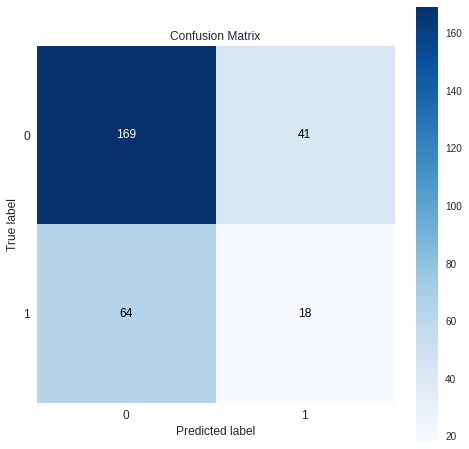

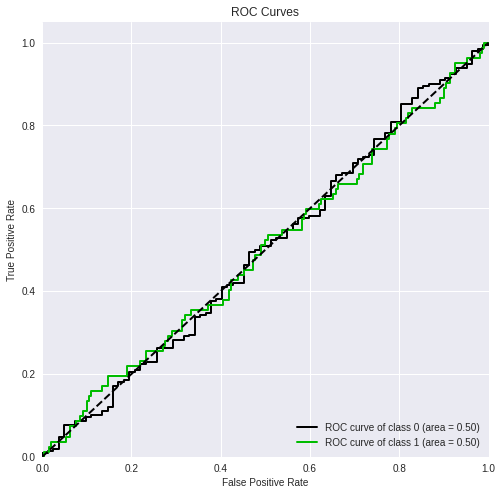

In [237]:
get_model_results(model_fs, g_test, Y_test, threshold=0.5)

In [43]:
def get_backtest_results(keras_model, g_test, df:pd.DataFrame, threshold=0.5, show_display=False):
    """
    Calculates backtest results using a keras model, a test generator dataset and the daily returns DataFrame (df),
    to get the trading strategy information. The threshold for the trading strategy can be varied to find the optimal
    threshold for a model.
    """
    Y_pred = np.where(keras_model.predict(g_test, verbose=False) > threshold, 1, 0)
    df_2 = pd.DataFrame(df.iloc[-1*Y_pred.shape[0]:])
    df_2['date'] = pd.to_datetime(df_2['date'])
    df_2.set_index('date', inplace=True)
    df_2['Signal'] = Y_pred
    df_2['Strategy'] = df_2['Forward_Return'] * df_2['Signal'].fillna(0)
    if show_display == True:
        display(pf.create_simple_tear_sheet(df_2['Strategy']))
          
    return df_2

Calculating Returns for Threshold = 0.5... 



Start date,2021-11-03
End date,2022-12-30
Total months,13
,Backtest
Annual return,8.6%
Cumulative returns,10.0%
Annual volatility,18.8%
Sharpe ratio,0.53
Calmar ratio,0.68
Stability,0.03
Max drawdown,-12.6%


None

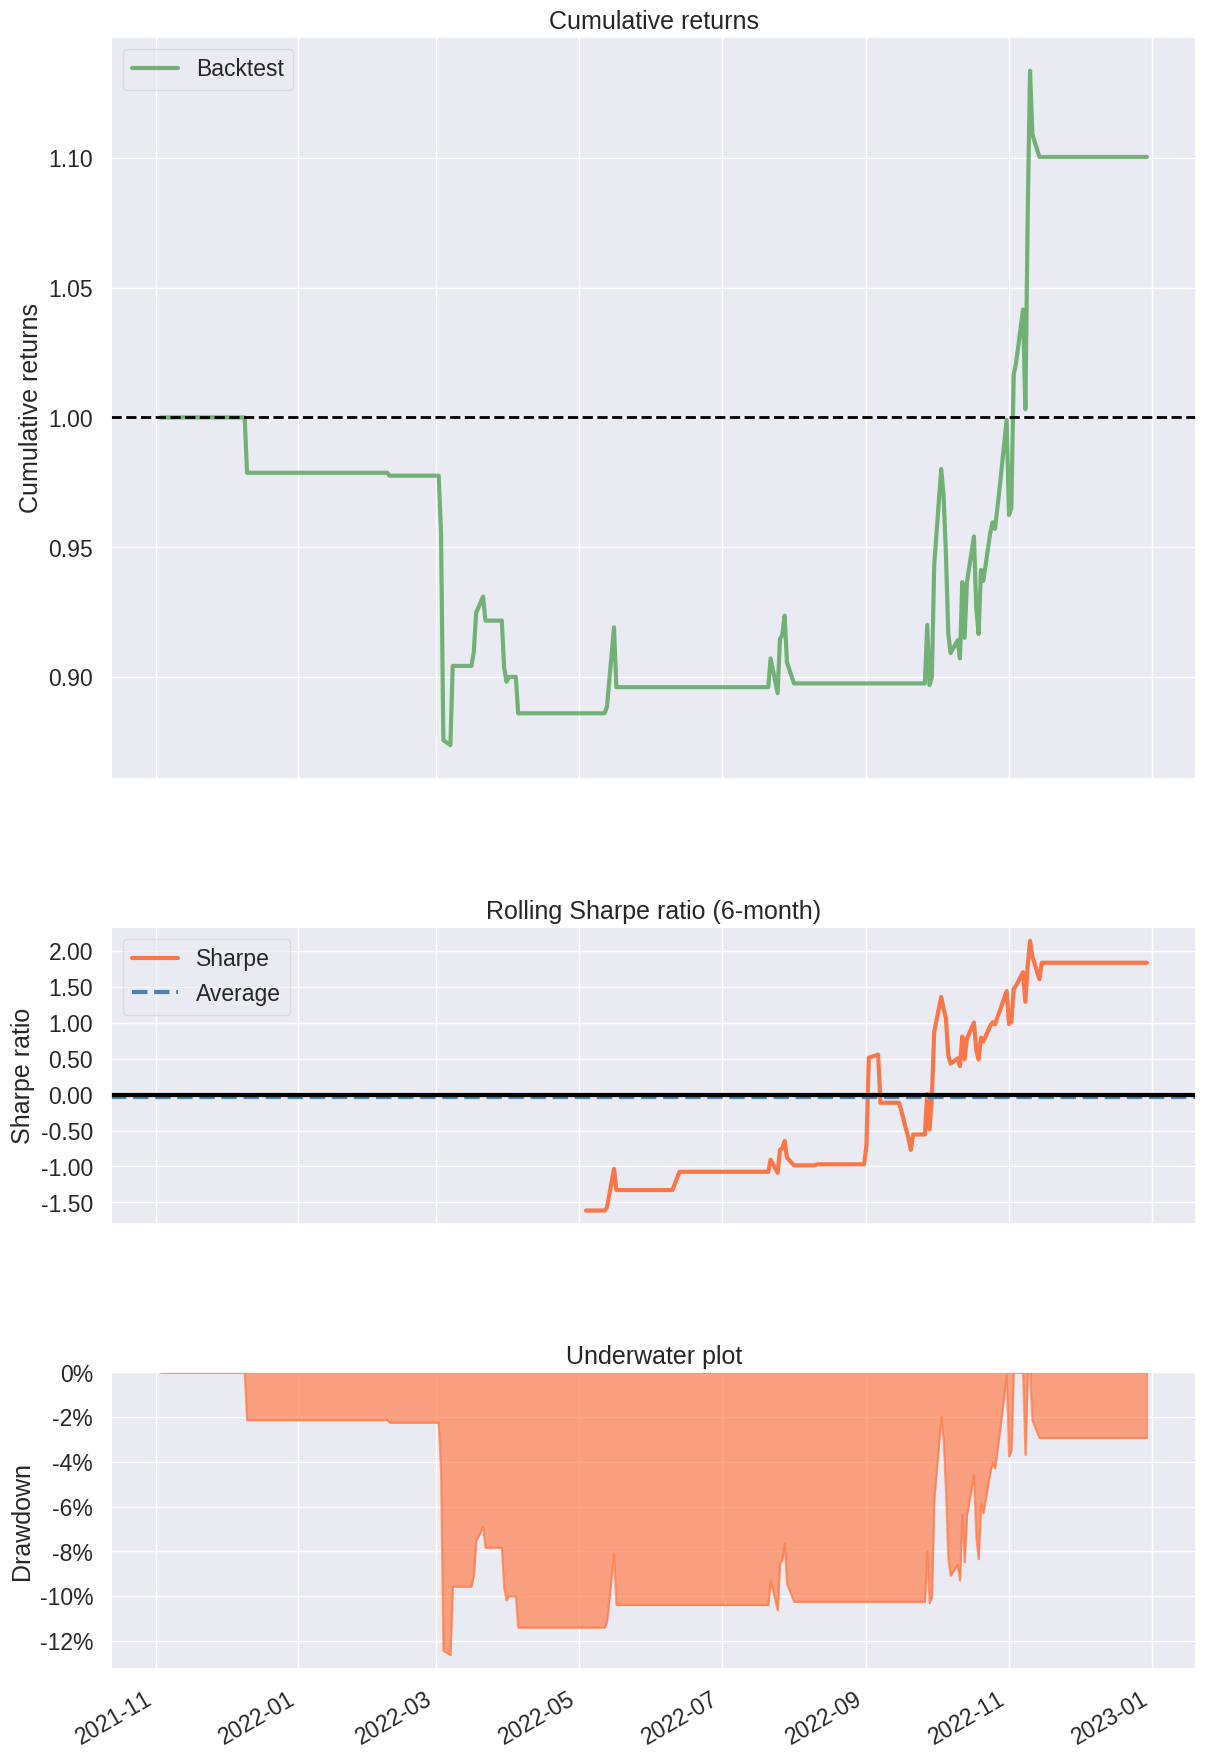

In [234]:
model_df_results = get_backtest_results(model_fs, g_test, df=model_df, vary_thresholds=False)

#### Evaluating Models for Backtest Performance

In this section, I will calculate the model backtest returns using the Empyrical Library, which is a re-direct from Quantopian's Pyfolio Library for calculating statistics on returns (https://github.com/quantopian/empyrical), to generate a Pandas DataFrame to compare which models were the best performing, across all thresholds from 0.1 to 0.9.

In [121]:
# List of Return Calculation Functions
ret_calc = [empyrical.annual_return,
            empyrical.cum_returns_final,
            empyrical.annual_volatility,
            empyrical.sharpe_ratio,
            empyrical.calmar_ratio,
            empyrical.stability_of_timeseries,
            empyrical.max_drawdown,
            empyrical.omega_ratio,
            empyrical.sortino_ratio,
            empyrical.tail_ratio,
            empyrical.value_at_risk]

In [152]:
%%time

def get_model_stats(model_dir, func_list, g_test=g_test, model_df=model_df):
    """
    Computes the returns by threshold for each model in directory of saved keras models.
    
    Input:
    model_dir: A string containing a filepath to a saved keras model object
    func_list: A list containing the list of functions to be applied to calculate strategy performance
    g_test: A TimeSeriesGenerator object containing the test set data
    model_df: A pandas DataFrame containing OHLC data, to compute returns, to be passed 
    into the get_backtest_results function
    
    """
    model_list = os.listdir(model_dir)
    column_list = [f.__name__ for f in func_list]
    stats_df = pd.DataFrame(columns=column_list)
    thresholds = [round(x,2) for x in np.linspace(0.1, 0.9, num=17).tolist()]
    for model_path in tqdm(model_list):
        print(f"Loading model: {model_dir}/{model_path}")
        temp_model = load_model(f"{model_dir}/{model_path}")        
        for t in thresholds:
            returns_df = get_backtest_results(temp_model, g_test, df=model_df, threshold=t)
            calcs = [x(returns_df['Strategy']) for x in func_list]
            stats_df = pd.concat([stats_df, pd.DataFrame(dict(zip(column_list, calcs)), index=[(model_path, t)])], axis=0)
    stats_df.index.name = "Model_and_Threshold"
    return stats_df

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.4 µs


#### Calculate the Strategy Performance

Calculate the trading strategy performance (statistics) for both Full and Reduced Dataset models here by varying the thresholds.

In [153]:
full_stats_df = get_model_stats("models/Full_Dataset", ret_calc, g_test=g_test, model_df=model_df)
ts_stats_df = get_model_stats("models/TS_Reduced_Dataset", ret_calc, g_test=g_test_ts, model_df=model_df)

now = dt.datetime.now(pytz.timezone('America/New_York'))
dt_string = now.strftime("%Y/%m/%d %H:%M:%S").replace("/", "_").replace(":", "_").replace(" ", "_")
model_stats_df = pd.concat([full_stats_df, ts_stats_df], axis=0)
model_stats_df.to_csv(f"Model_Backtest_Results_{dt_string}.csv")

  0%|          | 0/23 [00:00<?, ?it/s]

Loading model: models/Full_Dataset/hb_Dense_BiGRU_2023_01_09_20_18_33
Loading model: models/Full_Dataset/rs_Dense_BiLSTM_2023_01_08_22_20_30
Loading model: models/Full_Dataset/hb_Dense_LSTM_GRU_2023_01_09_23_20_36
Loading model: models/Full_Dataset/hb_Dense_BiRNN_2023_01_09_16_32_12
Loading model: models/Full_Dataset/rs_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_49_54
Loading model: models/Full_Dataset/hb_Dense_GRU_2023_01_09_18_24_38
Loading model: models/Full_Dataset/rs_Dense_LSTM_2_2023_01_08_22_07_05
Loading model: models/Full_Dataset/rs_Dense_LSTM_GRU_2023_01_08_23_43_30
Loading model: models/Full_Dataset/rs_Dense_BiRNN_2023_01_08_22_49_35
Loading model: models/Full_Dataset/hb_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_58_18
Loading model: models/Full_Dataset/rs_Dense_LSTM_RNN_2023_01_08_23_57_35
Loading model: models/Full_Dataset/rs_Dense_GRU_2023_01_08_23_02_59
Loading model: models/Full_Dataset/model_baseline_fs_1
Loading model: models/Full_Dataset/hb_Dense_BiLSTM_2023_01_09_12_40_49
Loa

  0%|          | 0/20 [00:00<?, ?it/s]

Loading model: models/TS_Reduced_Dataset/hb_LSTM_GRU__2023_01_11_15_12_44
Loading model: models/TS_Reduced_Dataset/rs_RNN__2023_01_11_07_48_49
Loading model: models/TS_Reduced_Dataset/hb_BiRNN__2023_01_11_12_04_57
Loading model: models/TS_Reduced_Dataset/hb_Conv_LSTM_RNN_GRU_2023_01_14_18_48_16
Loading model: models/TS_Reduced_Dataset/rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48
Loading model: models/TS_Reduced_Dataset/hb_LSTM__2023_01_11_09_32_33
Loading model: models/TS_Reduced_Dataset/hb_BiLSTM__2023_01_11_10_17_03
Loading model: models/TS_Reduced_Dataset/hb_BiGRU__2023_01_11_13_47_07
Loading model: models/TS_Reduced_Dataset/rs_GRU__2023_01_11_08_10_41
Loading model: models/TS_Reduced_Dataset/rs_LSTM_RNN_GRU__2023_01_11_09_19_35
Loading model: models/TS_Reduced_Dataset/rs_LSTM_RNN__2023_01_11_09_09_07
Loading model: models/TS_Reduced_Dataset/rs_LSTM_GRU__2023_01_11_08_52_37
Loading model: models/TS_Reduced_Dataset/rs_BiLSTM__2023_01_11_07_25_31
Loading model: models/TS_Reduced_Dataset/r

### Analyzing the Model Backtest Performance

Let's look at the trading strategy performance table to find the best strategies based on metrics such as annual return, cumulative return, etc.

In [154]:
model_stats_df.sort_values(by=['annual_return'], inplace=True, ascending=False)
model_stats_df.head(10)

,annual_return,cum_returns_final,annual_volatility,sharpe_ratio,calmar_ratio,stability_of_timeseries,max_drawdown,omega_ratio,sortino_ratio,tail_ratio,value_at_risk
Model_and_Threshold,,,,,,,,,,,
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.3)",0.326200,0.386982,0.216011,1.416332,2.701573,0.696813,-0.120744,1.561785,2.131562,1.446311,-0.016711
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.4)",0.299533,0.354718,0.164965,1.670131,4.023939,0.760185,-0.074438,1.791285,3.121923,2.040646,-0.009671
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.25)",0.292022,0.345648,0.228771,1.235606,1.768828,0.649074,-0.165093,1.423832,1.805710,1.179326,-0.021427
"(rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48, 0.4)",0.291482,0.344998,0.274664,1.068699,2.077065,0.363910,-0.140334,1.243978,1.607206,1.219728,-0.024670
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.45)",0.285256,0.337487,0.158404,1.662818,3.832132,0.640290,-0.074438,1.912127,3.190402,2.439572,-0.007858
"(rs_Dense_BiLSTM_2023_01_08_22_20_30, 0.55)",0.282276,0.333894,0.160071,1.633173,2.530641,0.917762,-0.111543,1.618476,2.847923,1.651557,-0.012125
"(rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48, 0.55)",0.271752,0.321217,0.196511,1.321985,2.558995,0.593005,-0.106195,1.458813,2.010329,1.447063,-0.016544
"(hb_LSTM_RNN_GRU__2023_01_11_16_42_15, 0.55)",0.257603,0.304200,0.213606,1.180360,2.338755,0.664828,-0.110146,1.332844,1.727629,1.108654,-0.022416
"(hb_Conv_LSTM_RNN_GRU_2023_01_14_18_48_16, 0.55)",0.255134,0.301233,0.237429,1.075332,1.639331,0.393643,-0.155633,1.298987,1.701457,1.209080,-0.022932


In [162]:
model_stats_df.sort_values(by=['cum_returns_final'], inplace=True, ascending=False)
model_stats_df.head(10)

,annual_return,cum_returns_final,annual_volatility,sharpe_ratio,calmar_ratio,stability_of_timeseries,max_drawdown,omega_ratio,sortino_ratio,tail_ratio,value_at_risk
Model_and_Threshold,,,,,,,,,,,
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.3)",0.326200,0.386982,0.216011,1.416332,2.701573,0.696813,-0.120744,1.561785,2.131562,1.446311,-0.016711
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.4)",0.299533,0.354718,0.164965,1.670131,4.023939,0.760185,-0.074438,1.791285,3.121923,2.040646,-0.009671
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.25)",0.292022,0.345648,0.228771,1.235606,1.768828,0.649074,-0.165093,1.423832,1.805710,1.179326,-0.021427
"(rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48, 0.4)",0.291482,0.344998,0.274664,1.068699,2.077065,0.363910,-0.140334,1.243978,1.607206,1.219728,-0.024670
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.45)",0.285256,0.337487,0.158404,1.662818,3.832132,0.640290,-0.074438,1.912127,3.190402,2.439572,-0.007858
"(rs_Dense_BiLSTM_2023_01_08_22_20_30, 0.55)",0.282276,0.333894,0.160071,1.633173,2.530641,0.917762,-0.111543,1.618476,2.847923,1.651557,-0.012125
"(rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48, 0.55)",0.271752,0.321217,0.196511,1.321985,2.558995,0.593005,-0.106195,1.458813,2.010329,1.447063,-0.016544
"(hb_LSTM_RNN_GRU__2023_01_11_16_42_15, 0.55)",0.257603,0.304200,0.213606,1.180360,2.338755,0.664828,-0.110146,1.332844,1.727629,1.108654,-0.022416
"(hb_Conv_LSTM_RNN_GRU_2023_01_14_18_48_16, 0.55)",0.255134,0.301233,0.237429,1.075332,1.639331,0.393643,-0.155633,1.298987,1.701457,1.209080,-0.022932


In [155]:
model_stats_df.sort_values(by=['sharpe_ratio'], inplace=True, ascending=False)
model_stats_df.head(10)

,annual_return,cum_returns_final,annual_volatility,sharpe_ratio,calmar_ratio,stability_of_timeseries,max_drawdown,omega_ratio,sortino_ratio,tail_ratio,value_at_risk
Model_and_Threshold,,,,,,,,,,,
"(hb_Dense_GRU_2023_01_09_18_24_38, 0.9)",0.138304,0.161951,0.062884,2.091366,10.033884,0.793392,-0.013784,4.628730,7.721899,NaN,0.000000
"(hb_BiLSTM__2023_01_11_10_17_03, 0.75)",0.120872,0.141358,0.059096,1.960171,19.038134,0.824781,-0.006349,20.492722,19.570059,NaN,0.000000
"(rs_Conv_LSTM_RNN_GRU_2023_01_14_18_38_48, 0.6)",0.241912,0.285363,0.129489,1.737991,2.404296,0.699347,-0.100616,1.815792,3.024959,2.114002,-0.007436
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.4)",0.299533,0.354718,0.164965,1.670131,4.023939,0.760185,-0.074438,1.791285,3.121923,2.040646,-0.009671
"(rs_Dense_GRU_2023_01_08_23_02_59, 0.45)",0.285256,0.337487,0.158404,1.662818,3.832132,0.640290,-0.074438,1.912127,3.190402,2.439572,-0.007858
"(rs_Dense_BiLSTM_2023_01_08_22_20_30, 0.55)",0.282276,0.333894,0.160071,1.633173,2.530641,0.917762,-0.111543,1.618476,2.847923,1.651557,-0.012125
"(hb_LSTM_RNN_GRU__2023_01_11_16_42_15, 0.9)",0.144241,0.168977,0.089675,1.547282,2.425097,0.409303,-0.059478,2.093885,2.939181,inf,0.000000
"(rs_Dense_BiGRU_2023_01_08_23_17_12, 0.4)",0.250269,0.295390,0.155941,1.510342,3.177403,0.915262,-0.078765,1.547678,2.485983,1.532240,-0.013446
"(rs_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_49_54, 0.85)",0.027560,0.032004,0.018268,1.497384,26.108662,0.478090,-0.001056,31.026119,27.893824,NaN,0.000000


In [156]:
model_stats_df.sort_values(by=['calmar_ratio'], inplace=True, ascending=False)
model_stats_df.head(10)

,annual_return,cum_returns_final,annual_volatility,sharpe_ratio,calmar_ratio,stability_of_timeseries,max_drawdown,omega_ratio,sortino_ratio,tail_ratio,value_at_risk
Model_and_Threshold,,,,,,,,,,,
"(rs_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_49_54, 0.85)",0.027560,0.032004,0.018268,1.497384,26.108662,0.478090,-0.001056,31.026119,27.893824,NaN,0.000000
"(hb_BiLSTM__2023_01_11_10_17_03, 0.75)",0.120872,0.141358,0.059096,1.960171,19.038134,0.824781,-0.006349,20.492722,19.570059,NaN,0.000000
"(rs_Dense_Conv_LSTM_RNN_GRU_2023_01_14_17_49_54, 0.9)",0.012337,0.014309,0.014326,0.862996,11.687226,0.144699,-0.001056,14.570937,12.607201,NaN,0.000000
"(hb_Dense_GRU_2023_01_09_18_24_38, 0.9)",0.138304,0.161951,0.062884,2.091366,10.033884,0.793392,-0.013784,4.628730,7.721899,NaN,0.000000
"(model_baseline_fs_1, 0.65)",0.021077,0.024463,0.017143,1.225222,9.646683,0.697594,-0.002185,12.139098,10.348058,NaN,0.000000
"(rs_Dense_LSTM_1_2023_01_08_21_54_39, 0.7)",0.066823,0.077833,0.058342,1.137123,6.463414,0.512859,-0.010339,8.435509,6.907478,NaN,0.000000
"(model_baseline_fs_1, 0.7)",0.012547,0.014553,0.015722,0.800868,5.742813,0.641429,-0.002185,7.677749,6.203531,NaN,0.000000
"(rs_Dense_BiGRU_2023_01_08_23_17_12, 0.9)",0.029505,0.034267,0.027136,1.084944,4.452574,0.717723,-0.006626,6.148217,4.782618,NaN,0.000000
"(hb_LSTM_GRU__2023_01_11_15_12_44, 0.7)",0.092439,0.107878,0.064283,1.407286,4.337231,0.855301,-0.021313,2.257515,3.101661,NaN,-0.000000


In [157]:
vol_df = pd.DataFrame(model_stats_df.loc[model_stats_df['annual_return'] > 0.05, :])
vol_df.sort_values(by=['annual_volatility'], inplace=True, ascending=True)
vol_df.head(10)

,annual_return,cum_returns_final,annual_volatility,sharpe_ratio,calmar_ratio,stability_of_timeseries,max_drawdown,omega_ratio,sortino_ratio,tail_ratio,value_at_risk
Model_and_Threshold,,,,,,,,,,,
"(rs_Dense_BiGRU_2023_01_08_23_17_12, 0.85)",0.060983,0.070999,0.046449,1.297430,2.755824,0.845062,-0.022129,3.240846,3.385345,NaN,0.0
"(rs_Dense_LSTM_GRU_2023_01_08_23_43_30, 0.85)",0.057587,0.067028,0.046536,1.226246,2.920947,0.397284,-0.019715,2.907182,2.706770,NaN,0.0
"(rs_Dense_LSTM_GRU_2023_01_08_23_43_30, 0.8)",0.069126,0.080530,0.048046,1.415100,2.873021,0.472566,-0.024061,2.782299,3.119996,NaN,0.0
"(hb_BiGRU__2023_01_11_13_47_07, 0.85)",0.057339,0.066738,0.050109,1.137389,1.811667,0.396164,-0.031650,3.000774,3.005426,NaN,0.0
"(rs_Dense_BiLSTM_2023_01_08_22_20_30, 0.9)",0.052345,0.060902,0.052580,0.996452,1.132730,0.696769,-0.046211,2.054266,1.812728,NaN,0.0
"(rs_Dense_BiLSTM_2023_01_08_22_20_30, 0.85)",0.058735,0.068370,0.053157,1.100105,1.270998,0.707510,-0.046211,2.148590,2.021183,NaN,0.0
"(rs_Dense_BiGRU_2023_01_08_23_17_12, 0.8)",0.056226,0.065437,0.053905,1.041566,1.990303,0.641133,-0.028250,1.979139,1.914610,NaN,0.0
"(rs_Dense_LSTM_1_2023_01_08_21_54_39, 0.7)",0.066823,0.077833,0.058342,1.137123,6.463414,0.512859,-0.010339,8.435509,6.907478,NaN,0.0
"(hb_BiLSTM__2023_01_11_10_17_03, 0.75)",0.120872,0.141358,0.059096,1.960171,19.038134,0.824781,-0.006349,20.492722,19.570059,NaN,0.0


### Get Best Model Info

Here are the model results for rs_Dense_GRU_2023_01_08_23_02_59, the model that had the highest annual return.

In [158]:
best_model = load_model("models/Full_Dataset/rs_Dense_GRU_2023_01_08_23_02_59")
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 472)         223256    
                                                                 
 dense_1 (Dense)             (None, None, 300)         141900    
                                                                 
 dense_2 (Dense)             (None, None, 230)         69230     
                                                                 
 GRU1 (GRU)                  (None, None, 32)          25344     
                                                                 
 Dropout1 (Dropout)          (None, None, 32)          0         
                                                                 
 GRU2 (GRU)                  (None, None, 24)          4176      
                                                                 
 Dropout2 (Dropout)          (None, None, 24)          0

3/3 [==============================] - 0s 7ms/step
Classification Report: 

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       210
           1       0.37      0.41      0.39        82

    accuracy                           0.64       292
   macro avg       0.57      0.57      0.57       292
weighted avg       0.65      0.64      0.65       292



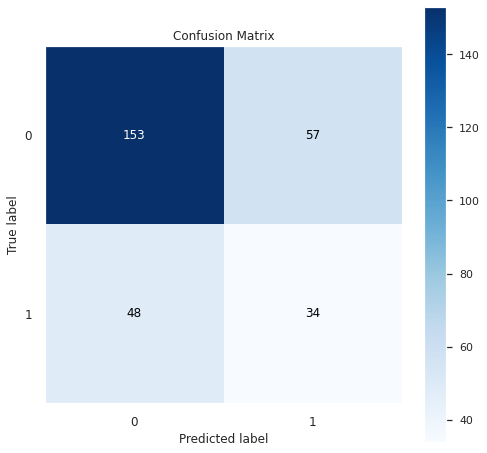

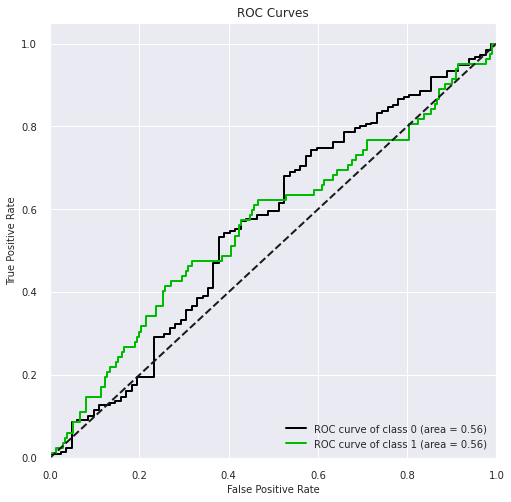

In [159]:
get_model_results(load_model("models/Full_Dataset/rs_Dense_GRU_2023_01_08_23_02_59"), g_test, Y_test, threshold=0.3)

Start date,2021-11-03
End date,2022-12-30
Total months,13
,Backtest
Annual return,32.6%
Cumulative returns,38.7%
Annual volatility,21.6%
Sharpe ratio,1.42
Calmar ratio,2.70
Stability,0.70
Max drawdown,-12.1%


None

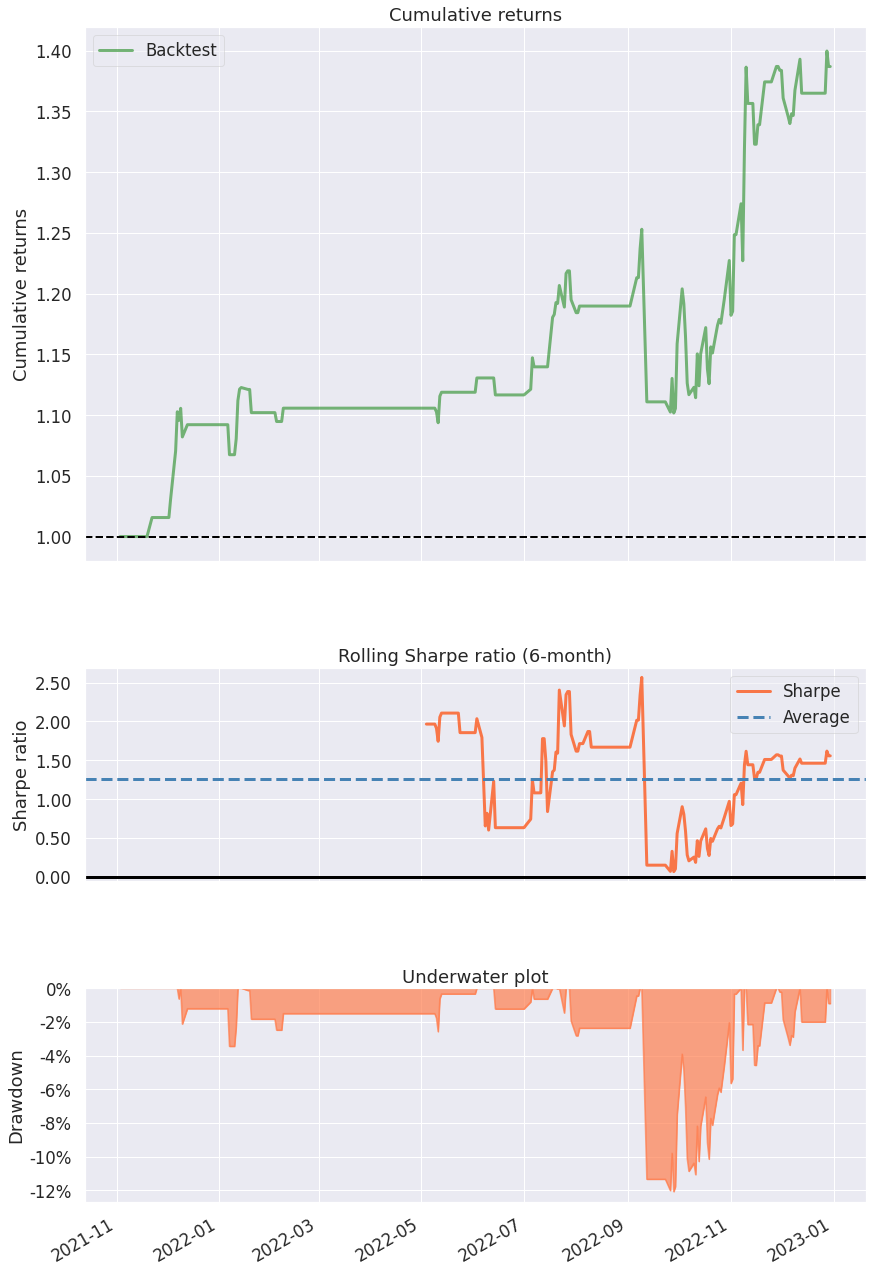

In [160]:
model_df_results = get_backtest_results(load_model("models/Full_Dataset/rs_Dense_GRU_2023_01_08_23_02_59"), g_test, df=model_df, threshold=0.3, show_display=True)

### Get Model Structures for All Models

Here, I will get the model summary for all models. I will move the output of the model summaries to a separate file to keep this Jupyter notebook more readable.

In [151]:
full_model_dir = "models/Full_Dataset" 
print("Full Data Models: ", len(os.listdir(full_model_dir)))

ts_model_dir = "models/TS_Reduced_Dataset"
print("TS Reduced Data Models: ", len(os.listdir(ts_model_dir)))

print("Total Models Built: ",  len(os.listdir(full_model_dir)) + len(os.listdir(ts_model_dir)))

Full Data Models:  23
TS Reduced Data Models:  20
Total Models Built:  43


In [ ]:
full_model_dir = "models/Full_Dataset"
for model_path in os.listdir(full_model_dir):
    loaded_model = load_model(f"{full_model_dir}/{model_path}")
    print("\n", model_path)
    print(loaded_model.summary(), "\n")

ts_model_dir = "models/TS_Reduced_Dataset"
for model_path in os.listdir(ts_model_dir):
    loaded_model = load_model(f"{ts_model_dir}/{model_path}")
    print("\n", model_path)
    print(loaded_model.summary(), "\n")

--------------------------------------------------------------------------

### End of Code